# Gender Analysis

In [59]:
import pandas as pd
import numpy as np
import json
import os

os.getcwd()

'C:\\Users\\92314\\OneDrive - Nova SBE\\DataG\\dego-project-team14-main\\notebooks'

In [61]:
file_path = "../data/raw_credit_applications.json"

with open(file_path, "r") as f:
    raw_data = json.load(f)

df = pd.json_normalize(raw_data)
df.head()

,_id,spending_behavior,processing_timestamp,applicant_info.full_name,applicant_info.email,applicant_info.ssn,applicant_info.ip_address,applicant_info.gender,applicant_info.date_of_birth,applicant_info.zip_code,...,financials.credit_history_months,financials.debt_to_income,financials.savings_balance,decision.loan_approved,decision.rejection_reason,loan_purpose,decision.interest_rate,decision.approved_amount,financials.annual_salary,notes
0,app_200,"[{'category': 'Shopping', 'amount': 480}, {'ca...",2024-01-15T00:00:00Z,Jerry Smith,jerry.smith17@hotmail.com,596-64-4340,192.168.48.155,Male,2001-03-09,10036,...,23,0.20,31212,False,algorithm_risk_score,NaN,NaN,NaN,NaN,NaN
1,app_037,"[{'category': 'Rent', 'amount': 608}, {'catego...",NaN,Brandon Walker,brandon.walker2@yahoo.com,425-69-4784,10.1.102.112,M,1992-03-31,10032,...,51,0.18,17915,False,algorithm_risk_score,NaN,NaN,NaN,NaN,NaN
2,app_215,"[{'category': 'Rent', 'amount': 109}]",NaN,Scott Moore,scott.moore94@mail.com,370-78-5178,10.240.193.250,Male,1989-10-24,10075,...,41,0.21,37909,True,NaN,vacation,3.7,59000.0,NaN,NaN
3,app_024,"[{'category': 'Fitness', 'amount': 575}]",NaN,Thomas Lee,thomas.lee6@protonmail.com,194-35-1833,192.168.175.67,Male,1983-04-25,10077,...,70,0.35,0,True,NaN,NaN,4.3,34000.0,NaN,NaN
4,app_184,"[{'category': 'Entertainment', 'amount': 463}]",2024-01-15T00:00:00Z,Brian Rodriguez,brian.rodriguez86@aol.com,480-41-2475,172.29.125.105,M,1999-05-21,10080,...,14,0.23,31763,False,algorithm_risk_score,NaN,NaN,NaN,NaN,NaN


In [9]:
df.columns.tolist()

['_id',
 'spending_behavior',
 'processing_timestamp',
 'applicant_info.full_name',
 'applicant_info.email',
 'applicant_info.ssn',
 'applicant_info.ip_address',
 'applicant_info.gender',
 'applicant_info.date_of_birth',
 'applicant_info.zip_code',
 'financials.annual_income',
 'financials.credit_history_months',
 'financials.debt_to_income',
 'financials.savings_balance',
 'decision.loan_approved',
 'decision.rejection_reason',
 'loan_purpose',
 'decision.interest_rate',
 'decision.approved_amount',
 'financials.annual_salary',
 'notes']

In [7]:
gender_col = 'applicant_info.gender'

# Check which gender values exist
df[gender_col].value_counts()

applicant_info.gender
Male      195
Female    193
F          58
M          53
            2
Name: count, dtype: int64

In [13]:
gender_col = 'applicant_info.gender'
decision_col = 'decision.loan_approved'  

# 1) Normalize gender values
df['gender_clean'] = df[gender_col].replace({
    'M': 'Male',
    'F': 'Female'
})

df['gender_clean'].value_counts()

gender_clean
Female    251
Male      248
            2
Name: count, dtype: int64

In [46]:
gender_col = 'applicant_info.gender'
decision_col = 'decision.loan_approved'

# 1) Normalize gender values
df['gender_clean'] = df[gender_col].replace({
    'M': 'Male',
    'F': 'Female'
})

# 2) Keep only Male/Female for fairness metrics and plots
mask = df['gender_clean'].isin(['Male', 'Female'])

approval_by_gender = (
    df[mask]
      .groupby('gender_clean')[decision_col]
      .mean()
      .rename('approval_rate')
)

approval_by_gender

gender_clean
Female    0.505976
Male      0.657258
Name: approval_rate, dtype: float64

In [17]:
approval_by_gender = (
    df.groupby('gender_clean')[decision_col]
      .mean()
      .rename('approval_rate')
)

approval_by_gender

gender_clean
          1.000000
Female    0.505976
Male      0.657258
Name: approval_rate, dtype: float64

In [18]:
rate_priv = approval_by_gender['Male']
rate_unpriv = approval_by_gender['Female']

di_ratio = rate_unpriv / rate_priv
rate_priv, rate_unpriv, di_ratio

(np.float64(0.657258064516129),
 np.float64(0.5059760956175299),
 np.float64(0.7698286608168553))

In [43]:
# Demographic parity difference: unprivileged - privileged
demographic_parity_diff = rate_unpriv - rate_priv
di_ratio, demographic_parity_diff

(np.float64(0.7698286608168553), np.float64(-0.15128196889859913))

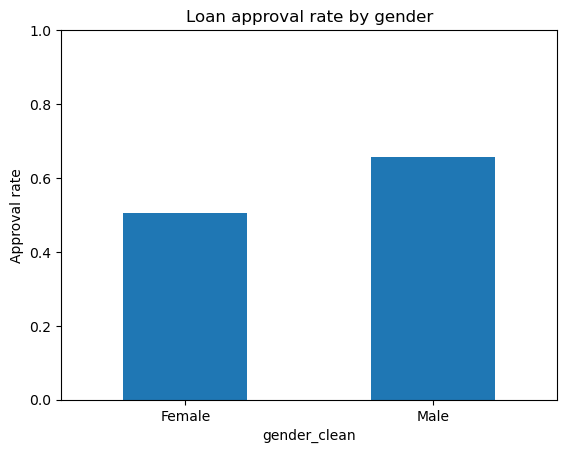

In [47]:
import matplotlib.pyplot as plt

approval_by_gender.plot(kind='bar', ylabel='Approval rate', title='Loan approval rate by gender', rot=0)
plt.ylim(0, 1)
plt.show()

### Gender bias – disparate impact

After normalizing gender values to `Male` and `Female`, and restricting the analysis to these two groups, we find that the loan approval rate is **65.7%** for male applicants and **50.6%** for female applicants. This corresponds to a disparate impact ratio of **0.77** (female approval rate divided by male approval rate), which is below the 0.80 `four‑fifths rule` threshold. This suggests potential disparate impact against female applicants that requires mitigation and ongoing governance controls.

In addition, the demographic parity difference (female minus male approval rate) is **−15.1 percentage points**, indicating that women are substantially less likely to be approved than men. We visualize this pattern with a bar chart of approval rates by gender, which clearly shows the lower approval rate for female applicants.

#### Gender data cleaning

The raw `applicant_info.gender` field contained multiple encodings for gender: `Male`, `Female`, `M`, `F`, and a small number of missing or other values. To obtain consistent categories for fairness analysis, we created a new variable `gender_clean` where `M` was mapped to `Male` and `F` to `Female`, keeping the other labels unchanged. Records with missing or invalid gender remain in the dataset but are excluded from comparisons that require a clear binary split (e.g., disparate impact between male and female applicants), so that fairness metrics are not distorted by ambiguous entries.


# Age Analysis

In [22]:
 dob_col = 'applicant_info.date_of_birth'

# Convert date_of_birth to datetime and compute age
df['dob'] = pd.to_datetime(df[dob_col], errors='coerce')
reference_year = 2024  # adjust if needed
df['age'] = reference_year - df['dob'].dt.year

# Create age buckets
age_bins = [0, 30, 50, 120]
age_labels = ['<30', '30-50', '50+']
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)

df['age_group'].value_counts(dropna=False)


age_group
30-50    199
NaN      162
<30       78
50+       63
Name: count, dtype: int64

In [25]:
df['age'].isna().mean()

np.float64(0.32270916334661354)

In [51]:
decision_col = 'decision.loan_approved'

approval_by_age = (
    df.dropna(subset=['age_group'])
      .groupby('age_group', observed=False)[decision_col]
      .mean()
      .rename('approval_rate')
)

approval_by_age


age_group
<30      0.397436
30-50    0.623116
50+      0.619048
Name: approval_rate, dtype: float64

In [53]:
# Disparate impact for age: <30 (unprivileged) vs 30-50 (privileged)
rate_under30 = approval_by_age.loc['<30']
rate_30_50 = approval_by_age.loc['30-50']

di_age_under30_vs_30_50 = rate_under30 / rate_30_50
rate_under30, rate_30_50, di_age_under30_vs_30_50

(np.float64(0.3974358974358974),
 np.float64(0.6231155778894473),
 np.float64(0.6378205128205128))

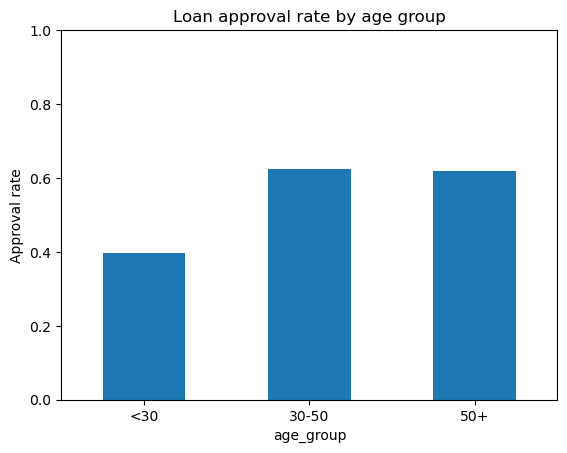

In [54]:
import matplotlib.pyplot as plt

approval_by_age.plot(
    kind='bar',
    ylabel='Approval rate',
    title='Loan approval rate by age group',
    rot=0
)
plt.ylim(0, 1)
plt.show()

### Age-based approval patterns

We grouped applicants into three age bands: **<30**, **30–50**, and **50+**. Using these buckets, the approval rates are approximately **39.7%** for applicants under 30, **62.3%** for those aged 30–50, and **61.9%** for applicants over 50. This shows that younger applicants are much less likely to be approved than older ones, even though they are applying for the same credit product.

Treating applicants **<30** as an unprivileged group and **30–50** as the reference (privileged) group, we compute a disparate impact ratio (approval rate <30 divided by approval rate 30–50) that is well below 0.8, indicating a potential age-related disparity that warrants governance attention. We also visualize these differences with a bar chart of approval rates by age group, which clearly highlights the lower approval rate for the youngest band.

### Age data cleaning

The original `applicant_info.date_of_birth` field contained missing and inconsistently formatted values. To use it in the bias analysis, we first converted it to a proper datetime type and then computed an approximate age (using a reference year) for each applicant.

During this step, any invalid or missing dates were converted to `NaT`, which means the corresponding age is `NaN`. Around **32%** of records have `NaN` age and are therefore excluded from the age-group approval rate calculations (`<30`, `30–50`, `50+`). We treat this loss of information as a data-quality issue in itself, because it can hide or distort age-related bias if not explicitly documented.

# ZIP Proxy Analysis

In [31]:
zip_col = 'applicant_info.zip_code'
decision_col = 'decision.loan_approved'

# Approval rate by ZIP and gender (using cleaned gender)
group_zip_gender = (
    df.groupby([zip_col, 'gender_clean'], observed=False)[decision_col]
      .agg(['mean', 'count'])
      .rename(columns={'mean': 'approval_rate', 'count': 'n'})
)

# Keep only ZIP codes with enough observations (e.g., at least 20)
proxy_check = group_zip_gender[group_zip_gender['n'] >= 5]
proxy_check.sort_values('approval_rate', ascending=False).head(20)


,,approval_rate,n
applicant_info.zip_code,gender_clean,,
10004,Male,1.000000,6
10012,Male,1.000000,5
10092,Male,1.000000,5
10048,Male,0.857143,7
90252,Female,0.800000,5
10020,Male,0.666667,6
10002,Male,0.600000,5
10041,Male,0.600000,5
90237,Female,0.600000,5


In [58]:
# Aggregate to ZIP level: how many males vs females per ZIP
zip_summary = (
    proxy_check.reset_index()
    .pivot_table(index='applicant_info.zip_code',
                 columns='gender_clean',
                 values='n',
                 aggfunc='sum',
                 fill_value=0)
)

zip_summary.head()

zip_with_both

Index([], dtype='object', name='applicant_info.zip_code')

In [39]:
proxy_check.shape
proxy_check.head()

,,approval_rate,n
applicant_info.zip_code,gender_clean,,
10002,Male,0.600000,5
10004,Male,1.000000,6
10012,Male,1.000000,5
10019,Male,0.400000,5
10020,Male,0.666667,6


In [40]:
zip_gender_counts = (
    proxy_check
    .reset_index()
    .groupby('applicant_info.zip_code')['gender_clean']
    .nunique()
)

zip_gender_counts.head()

applicant_info.zip_code
10002    1
10004    1
10012    1
10019    1
10020    1
Name: gender_clean, dtype: int64

In [41]:
zip_gender_counts.value_counts()

gender_clean
1    15
Name: count, dtype: int64

In [55]:
zip_summary = (
    proxy_check
    .reset_index()
    .groupby(['applicant_info.zip_code', 'gender_clean'])['n']
    .sum()
    .unstack(fill_value=0)
)

zip_summary.head()

gender_clean,Female,Male
applicant_info.zip_code,,
10002,0,5
10004,0,6
10012,0,5
10019,0,5
10020,0,6


In [56]:
# Total and max share (purity) per ZIP
zip_summary['total'] = zip_summary.sum(axis=1)
zip_summary['max_share'] = zip_summary[['Female', 'Male']].max(axis=1) / zip_summary['total']

# Sort by purity descending
zip_purity = zip_summary.sort_values('max_share', ascending=False)

zip_purity.head(10)

gender_clean,Female,Male,total,max_share
applicant_info.zip_code,,,,
10002,0,5,5,1.0
10004,0,6,6,1.0
10012,0,5,5,1.0
10019,0,5,5,1.0
10020,0,6,6,1.0
10041,0,5,5,1.0
10044,0,5,5,1.0
10048,0,7,7,1.0
10057,0,6,6,1.0


In [57]:
single_gender_zips = (zip_purity['max_share'] == 1.0).sum()
total_zips = zip_purity.shape[0]
single_gender_zips, total_zips

(np.int64(15), 15)

### Proxy discrimination – ZIP code as a proxy for gender

We first tried to identify ZIP codes that contained **both** male and female applicants and compare their approval rates within the same ZIP. However, in our filtered sample (ZIPs with at least 5 applications) there were **no** ZIP codes with more than one gender present, so this within‑ZIP comparison was not possible.

Instead, we aggregated applications by ZIP code and gender. For each ZIP we computed the number of male and female applicants and a “purity” measure (share of the dominant gender). We find that **all 15 ZIP codes** in our filtered sample are **100% single‑gender** (purity = 1.0) – for example, ZIP **10004** contains 6 male applications and 0 female applications, and several other ZIPs show the same pattern of being exclusively male or exclusively female.

This means that even if we removed the explicit gender field, a model using ZIP code as a feature could still infer gender with very high confidence. In practice, ZIP behaves as a strong proxy for gender, so decisions based on ZIP can reproduce gender disparities while appearing neutral. From a governance perspective, ZIP should therefore be treated as a high‑risk feature whose use must be clearly justified, constrained (e.g., coarsened to regions), or closely monitored for indirect discrimination.